In [1]:
import flickrapi
import urllib.request
from PIL import Image
import csv
import os
import glob
from IPython.display import HTML
from io import BytesIO
from clarifai.rest import ClarifaiApp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import datetime

os.chdir('C:/Users/mahmud/Desktop/Research/Galapagos/Python/Flikr Scraping/Images/Tortoise1')

In [2]:
# enter flickr API key and secret
# create API Key here: https://www.flickr.com/services/apps/create/apply
api_key = '41edd63028dfb86955ed4d3cf9b4e4ec'
api_secret = 'ecebf3e7487090e0'
flickr = flickrapi.FlickrAPI(api_key, api_secret, cache=True)


In [3]:
maxlon=-90.2357; minlon=-90.50186
minlat=-0.760444; maxlat=-0.539408

def walkingbound(bbox, xdim, ydim):
    x = bbox[2] - bbox[0]
    y = bbox[3] - bbox[1]
    x_inc = x / xdim
    y_inc = y / ydim
    coords = {'minlong':[bbox[0]], 'minlat':[bbox[1]], 'maxlon':[bbox[2]], 'maxlat':[bbox[3]]}
    df = pd.DataFrame(data=coords)
    
    for i in range(xdim):
        for a in range(ydim):
            #a = a + 1
            xmin = bbox[0] + (x_inc * i)
            ymin = bbox[1] + (y_inc * a)
            xmax = bbox[2] - (x_inc * i)
            ymax = bbox[3] - (y_inc * a)
            pts = {'minlon':[xmin], 'minlat':[ymin], 'maxlon':[xmax], 'maxlat':[ymax]}
            pts_df = pd.DataFrame(pts)
            df = df.append(pts_df)
    df = df.reset_index(drop=True)
    df = df.drop([0])
    df = df.reset_index(drop=True)
    
    box_num = dim1 * dim2
    coords = [None] * box_num
    coord_list = [None] * box_num
    
    for i in range(box_num - 1):
        coords[0] = [bbox[0], bbox[1], df['minlon'][xdim + 1], df['minlat'][ydim + 1]]
        coords[i + 1] = [df.loc[i + 1, 'minlon'], df.loc[i + 1, 'minlat'], 
                         df.loc[box_num - (i + 2), 'maxlon'], df.loc[box_num - (i + 2), 'maxlat']]
        coord_list[0] =  str(coords[0][0]) + ',' + str(coords[0][1]) + ',' + str(coords[0][2]) + ',' + str(coords[0][3])
        coord_list[i + 1] =  str(coords[i][0]) + ',' + str(coords[i][1]) + ',' + str(coords[i][2]) + ',' + str(coords[i][3])
    
    return coords

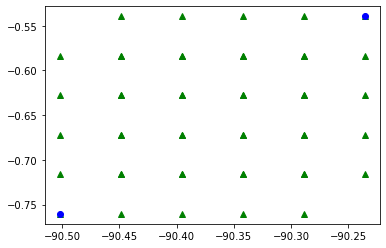

In [4]:
bbox_macro=[minlon, minlat, maxlon, maxlat]

dim1 = 5
dim2 = 5

boxes = walkingbound(bbox_macro, dim1, dim2)

lons = [None] * len(boxes)
lons1 = [None] * len(boxes)
lats = [None] * len(boxes)
lats1 = [None] * len(boxes)

a = -1
for i in range(len(boxes)):
    lons[i] = float(boxes[i][0])
    lons1[i] = float(boxes[i][2])
    lats[i] = float(boxes[i][1])
    lats1[i] = float(boxes[i][3])
    
lons = lons + lons1
lats = lats + lats1

macro_lon = [bbox_macro[0], bbox_macro[2]]
macro_lat = [bbox_macro[1], bbox_macro[3]]

plt.plot(lons, lats, 'g^')
plt.plot(macro_lon, macro_lat, 'bo')

In [5]:
# filter search by keyword to further limit scope of query
#keyword = 'tortoise'

# set cutoff point for image query
queryCutoff = 2000

run = 1
pic = 0
pic_tot = 0

# In[0]:

url_total = []


for bounding_box in boxes:

#bounding_box = bbox_macro#boxes[12]
    
    print("Run number: ", run, " of ", dim1 * dim2)
    bbox = str(bounding_box[0]) + ',' + str(bounding_box[1]) + ',' + str(bounding_box[2]) + ',' + str(bounding_box[3])

    photos = flickr.walk(
        #text=keyword,
        tag_mode='all',
        #tags=keyword,
        min_upload_date=36526,
        bbox= bbox,
        extras='url_c,geo,date_taken',
        per_page=200,
        sort='relevance')
    
    urls = []
    for i, photo in enumerate(photos):
        url = photo.get('url_c')
        urls.append(url)
    
        if i > queryCutoff:
            break
    
    #print(urls)
    
    ## download and resize photos to working directory
    responseLen = len(urls)
    for i in range(0, responseLen):
        try:
            if urls[i] not in url_total:
                urllib.request.urlretrieve(urls[i], str(i) + 'Run' + str(run) + '.jpg') #str(pic)
                Image.open(str(i) + 'Run' + str(run) + '.jpg').resize((256, 256), Image.ANTIALIAS).save(str(i) + 'Run' + str(run) + '.jpg')
                url_total.append(urls[i])
                pic = pic + 1
                pic_tot = pic_tot + 1
        except:
            pass
    
    # QUERY IMAGE METADATA
    imageIDs = []
    latitudes = []
    longitudes = []
    dates = []
    
    for i, url in enumerate(photos):
        # image ID
        imageID = url.attrib['id']
        imageIDs.append(imageID)
    
        # datetaken
        datetaken = url.attrib['datetaken']
        dates.append(datetaken)
        
        # latitude
        latitude = url.attrib['latitude']
        latitudes.append(latitude)
        # longitude
        longitude = url.attrib['longitude']
        longitudes.append(longitude)
        
        # csv parameters
        file_exists = os.path.isfile('img-metadata.csv')
        with open('img-metadata' + str(run) + '.csv', 'a') as csvfile:
            headers = ['id', 'url', 'datetaken', 'imgName', 'latitude', 'longitude']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()
                for i, url in enumerate(photos):
                    writer.writerow({
                        'id': url.attrib['id'],
                        'url': 'http://flickr.com/photo.gne?id=' + str(url.attrib['id']),
                        'datetaken': url.attrib['datetaken'],
                        'imgName': str(i) + 'Run' + str(run) +  '.jpg',
                        'latitude': url.attrib['latitude'],
                        'longitude': url.attrib['longitude']
                    })
                    if i >= queryCutoff:
                        break
        # break the loop
        if i >= queryCutoff:
            break
    
    print('Pictures downloaded:', pic)
    print('Total pictures downloaded: ', pic_tot)
    pic = 0
    run = run + 1
        #
        #

Run number:  1  of  25
Pictures downloaded: 0
Total pictures downloaded:  0
Run number:  2  of  25
Pictures downloaded: 2
Total pictures downloaded:  2
Run number:  3  of  25
Pictures downloaded: 359
Total pictures downloaded:  361
Run number:  4  of  25
Pictures downloaded: 1
Total pictures downloaded:  362
Run number:  5  of  25
Pictures downloaded: 5
Total pictures downloaded:  367
Run number:  6  of  25
Pictures downloaded: 42
Total pictures downloaded:  409
Run number:  7  of  25
Pictures downloaded: 384
Total pictures downloaded:  793
Run number:  8  of  25
Pictures downloaded: 898
Total pictures downloaded:  1691
Run number:  9  of  25
Pictures downloaded: 0
Total pictures downloaded:  1691
Run number:  10  of  25
Pictures downloaded: 0
Total pictures downloaded:  1691
Run number:  11  of  25
Pictures downloaded: 3
Total pictures downloaded:  1694
Run number:  12  of  25
Pictures downloaded: 72
Total pictures downloaded:  1766
Run number:  13  of  25
Pictures downloaded: 341
Tot

In [6]:
img_df = pd.DataFrame()
for file in glob.glob("*.csv"):
    temp_df = pd.read_csv(file)
    img_df = img_df.append(temp_df)
img_df = img_df.reset_index(drop=True)

In [7]:
wd = str(os.getcwd())
img_df['path'] = wd + '/' + img_df['imgName']
img_df.head()


,id,url,datetaken,imgName,latitude,longitude,path
0,30122690896,http://flickr.com/photo.gne?id=30122690896,2016-10-06 15:41:02,0Run16.jpg,-0.743206,-90.313517,C:\Users\mahmud\Desktop\Research\Galapagos\Pyt...
1,29521929763,http://flickr.com/photo.gne?id=29521929763,2016-10-06 08:26:13,1Run16.jpg,-0.743206,-90.313517,C:\Users\mahmud\Desktop\Research\Galapagos\Pyt...
2,29345256022,http://flickr.com/photo.gne?id=29345256022,2016-08-18 19:00:28,2Run16.jpg,-0.748475,-90.313153,C:\Users\mahmud\Desktop\Research\Galapagos\Pyt...
3,28830272033,http://flickr.com/photo.gne?id=28830272033,2016-08-18 16:20:07,3Run16.jpg,-0.747338,-90.313625,C:\Users\mahmud\Desktop\Research\Galapagos\Pyt...
4,28933211586,http://flickr.com/photo.gne?id=28933211586,2016-07-22 18:14:56,4Run16.jpg,-0.747059,-90.311940,C:\Users\mahmud\Desktop\Research\Galapagos\Pyt...


In [8]:
pd.options.mode.chained_assignment = None
download = [None] * len(img_df['imgName'])
img_df['download'] = None
files = []

for file in glob.glob("*.jpg"):
    files.append(file)

for i in range(len(download)):
    if str(img_df.loc[i, 'imgName']) in files:
        img_df['download'][i] = True
    else:
        img_df['download'][i] = None

df2 = img_df.dropna()
df2 = df2.reset_index(drop=True)


In [9]:
print('Number of images to classify: ', len(df2))




Number of images to classify:  1795


In [10]:
print(range(len(df2['path'])))

range(0, 1795)


In [ ]:
## df2['classify'] = None
plt.ion()
#len(df2)
for i in range(len(df2['path'])):
    #try:
    image = imread(df2['path'][i])
    plt.imshow(image)
    plt.axis('off')
    plt.pause(0.5)
    print('Image number ', str(i), ' of ', str(len(df2['path'])))
    df2['classify'][i] = input('classify 1 (Use) or 2 (Do Not Use): ')
    #except:
    #print(df2['path'][i])
    #    pass

In [ ]:
selected = df2['classify'] == '1'
df3 = df2[selected]


In [ ]:
writer = pd.ExcelWriter('manual_check.xlsx')
df3.to_excel(writer,'Sheet1')
writer.save()

In [ ]:
df3 = df3.sort_values(by=['datetaken'])

In [ ]:
df3['year'] = None
for i, date in enumerate(df3['datetaken']):
    df3['datetaken'][i] = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')


In [ ]:
df3['datetaken'][0].year == 2005


In [ ]:
plt.plot(df3['latitude'], df3['longitude'], 'ro')
